In [3]:
%reload_ext autoreload
%autoreload 2

In [84]:
import torch
from torch import nn
from torchvision import transforms, models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [23]:
class Hook():
    "Create a hook on `m` with `hook_func`."
    def __init__(self, m, hook_func, is_forward=True, detach=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module, input, output):
        "Applies `hook_func` to `module`, `input`, `output`."
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()
        self.stored = self.hook_func(module, input, output)

    def remove(self):
        "Remove the hook from the model."
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.remove()

def _hook_inner(m,i,o):
    return o if isinstance(o,torch.Tensor) else o if is_listy(o) else list(o)

def hook_output(model, detach=True, grad=False):
    return Hook(model, _hook_inner, detach=detach, is_forward=not grad)

def is_listy(obj):
    return (type(obj) == type([])) or (type(obj) == type((1,2)))

In [53]:
nn.Module.__getitem__ = lambda this,i: list(this.children())[i]

In [179]:
def denorm(img):
    return img.add(1).div(2).mul(255).clamp(0,255).permute(1,2,0).numpy().astype('uint8')

In [327]:
def gradcam(model, img, im_class, layer_num=0, heatmap_thresh:int=16, image:bool=True):
    m = model.eval()
    cl = int(im_class)
#     xb,_ = self.data.one_item(im, detach=False, denorm=False) #put into a minibatch of batch size = 1
    xb = img

    with hook_output(m[layer_num]) as hook_a:
        with hook_output(m[layer_num], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cl)].backward()
    acts  = hook_a.stored[0].cpu() #activation maps
    if (acts.shape[-1]*acts.shape[-2]) >= heatmap_thresh:
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = F.relu(((acts*grad_chan[...,None,None])).sum(0))
        if image:
            xb_im = Image.fromarray(denorm(xb[0]))
            _,ax = plt.subplots()
            sz = list(xb_im.size)
            ax.imshow(xb_im)
            ax.imshow(mult, alpha=0.4, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')
        return mult


In [328]:
net = models.resnet18(pretrained=True)

In [329]:
img = torch.randn(1,3,224,224)

In [330]:
IMSIZE = 224
img = Image.open('dog.jpg')
tfms = transforms.Compose([
    transforms.Resize((IMSIZE, IMSIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
img = tfms(img)

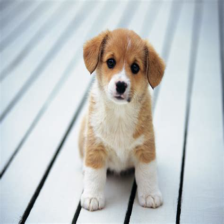

In [331]:
Image.fromarray(denorm(img))

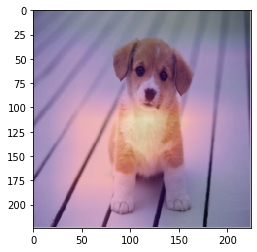

In [359]:
gradcam(net, img[None], 767, layer_num=7);

In [366]:
with hook_output(list(net.children())[2]) as hook_a:
    preds = net(img[None])
        
acts  = hook_a.stored[0].cpu()

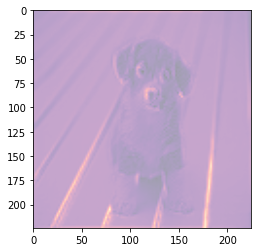

In [367]:
_,ax = plt.subplots()
sz = [224,224]
ax.imshow(F.relu(acts.sum(0)), alpha=0.4, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')